# Music playlist creation using clustering analysis

#### We use a dataset of songs from spotify with several attributes
#### We focus on the attributes that define the song, i.e.  'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
#### These attributes will be used to cluster songs, songs in the same cluster will be similar to each other and can be put in the same playlist
#### We will use 4 clustering algorithms: KMeans, Agglomerative, DBSCAN and KMediods and comapre the output clusters from each of these algorithms

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

##### Due to the high processing that this project demands, it has been done on Google colab
##### The code below reads the dataset which we work on form your personal Google Drive

In [2]:


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

##### Code to fetch dataset from Google Drive

In [3]:

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = "https://drive.google.com/file/d/1nnryaPk_UvtNhVz12xn5GRBIM66jHqnY/view?usp=sharing"
id = "1nnryaPk_UvtNhVz12xn5GRBIM66jHqnY"

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('spotify_songs.csv')  
song_df=  pd.read_csv('spotify_songs.csv')

##### we now set the maximum columns to be display to 500 and view the data
##### The dataset has 18454 rows and 26 columns
##### we will be using only the columns relevant to our clustering analysis

In [6]:
pd.set_option('display.max_columns', 500)
song_df.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,rock,classic rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,r&b,neo soul,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,pop,dance pop,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


# Select required features for clustering
##### we select the relevant columns 

In [7]:
song_data = song_df[['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Check if the features follow Gaussian distribution
##### If the columns don't follow a Gaussian Distribution then we normalise using the Standard Scaler

In [8]:
from scipy.stats import shapiro

stat,p =shapiro(song_data[['danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']])

print("stat: ",stat,":","p :",p)
if p>0.05:
    print("gaussian distribution - fail to reject H0")
else:
    print("not gaussian distribution - reject H0")

stat:  0.4006919860839844 : p : 0.0
not gaussian distribution - reject H0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Standardize using Standard Scaler
##### After normalising using Standard Scaler, we now have the data on which we can perform clustering
#### We use the 11 columns relevant to us

In [9]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


scaled = scaler.fit_transform(song_data[['danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']])
songs_normalized = pd.DataFrame(scaled, columns=[['danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']])

songs_normalized

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.252779,-1.612626,-0.925013,-1.129478,0.850047,-0.807439,0.475927,-0.234851,-0.656229,0.198512,-0.859909
1,-2.272760,1.039196,1.012423,0.695098,0.850047,-0.606048,-0.751409,-0.245311,1.023809,-0.509808,0.522475
2,1.338961,-0.223049,0.182093,-0.251600,-1.176405,1.073519,-0.785295,-0.261417,1.947406,0.565789,-0.322927
3,-1.459790,-1.739958,-0.094684,0.325321,-1.176405,-0.704788,2.358484,-0.304386,-0.801273,-0.505436,-0.080446
4,0.772547,1.077949,1.012423,1.635291,0.850047,-0.638310,-0.635241,-0.304386,-0.335571,-1.226873,0.333718
...,...,...,...,...,...,...,...,...,...,...,...
18449,-1.099950,0.596303,1.289199,0.339359,-1.176405,-0.179802,-0.779647,-0.304386,0.945758,-1.353671,0.260999
18450,2.125277,-0.494321,-0.925013,0.186655,0.850047,0.721572,-0.496116,-0.304351,0.158749,0.552672,0.332703
18451,-1.239888,-0.843099,-0.094684,0.106879,-1.176405,-0.774200,2.477865,-0.301843,-0.485168,0.596395,0.775976
18452,1.252333,-0.145543,-1.201790,0.633127,-1.176405,-0.419321,-0.148531,-0.304386,-0.764849,1.265364,-0.408769


## Principal Component Analysis
##### We are dealing with a dataset that has 11 dimensions. To calculate and visualize the clusters in 2 dimensions, we use PCA to reduce the higher dimenions to lower dimensions
##### Our data is now ready for clustering

In [10]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(songs_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']
print(X_principal.head())


         P1        P2
0  2.110103 -0.199195
1 -1.547613  2.286305
2 -0.513070 -1.655669
3  2.237321  0.873361
4 -1.653252  0.396444


# KMEANS model:




## part 1 : determining number of clusters using elbow method graph
##### Kmeans is a simple clustering algorithm. But it is very sensitive to outliers

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


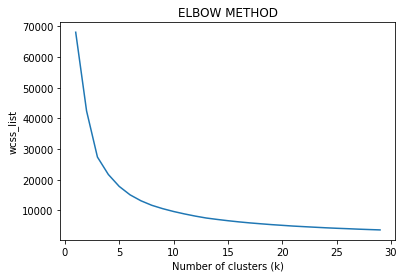

In [11]:

X = X_principal.iloc[:,[0,1]].values
from sklearn.cluster import KMeans

wcss_list = []

for i in range(1,30):
    kmeans = KMeans(n_clusters = i ,init = "k-means++",random_state=42)
    kmeans.fit(X)
    wcss_list.append(kmeans.inertia_)
    print(i)
    
plt.plot(range(1,30), wcss_list)
plt.title("ELBOW METHOD")
plt.xlabel('Number of clusters (k)')
plt.ylabel("wcss_list")
plt.show()

## part 2: visualizing clusters

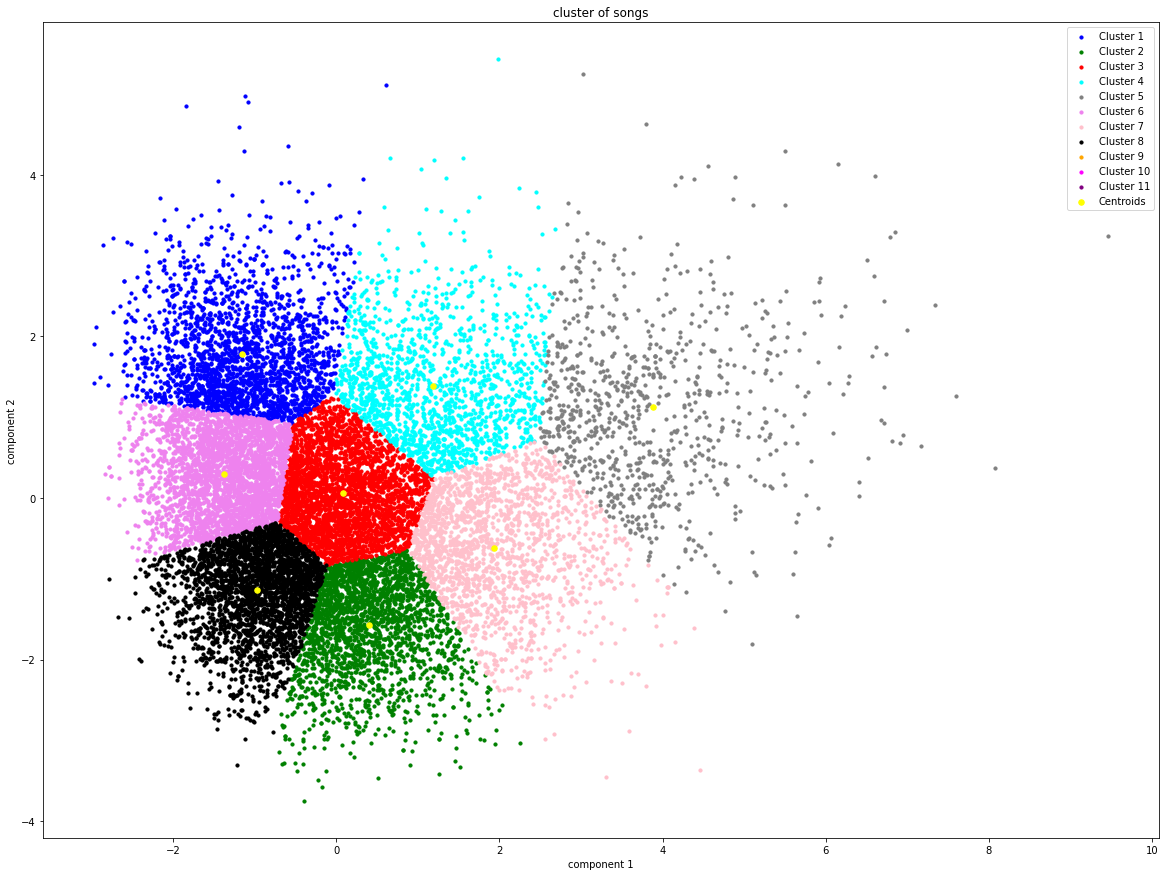

In [29]:
#from the graph we determine that 8 is the optimal number of clusters, so we apply kmens with 8 clusters
kmeans = KMeans(n_clusters = 8 ,init = "k-means++",random_state=42)
y_predict = kmeans.fit_predict(X)

# visualization code
plt.figure(figsize=(20, 15))

plt.scatter(X[y_predict == 0,0],X[y_predict == 0,1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(X[y_predict == 1,0],X[y_predict == 1,1], s = 10, c = 'green', label = 'Cluster 2')
plt.scatter(X[y_predict == 2,0],X[y_predict == 2,1], s = 10, c = 'red', label = 'Cluster 3')
plt.scatter(X[y_predict == 3,0],X[y_predict == 3,1], s = 10, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_predict == 4,0],X[y_predict == 4,1], s = 10, c = 'gray', label = 'Cluster 5')

plt.scatter(X[y_predict == 5,0],X[y_predict == 5,1], s = 10, c = 'violet', label = 'Cluster 6')
plt.scatter(X[y_predict == 6,0],X[y_predict == 6,1], s = 10, c = 'pink', label = 'Cluster 7')
plt.scatter(X[y_predict == 7,0],X[y_predict == 7,1], s = 10, c = 'black', label = 'Cluster 8')



plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s=30,c='yellow',label = 'Centroids')
plt.title('cluster of songs')
plt.xlabel('component 1')
plt.ylabel("component 2")
plt.legend()
plt.show()

# Agglomerative Model:
##### To get the optimal number of clusters for Agglomerative clustering, we draw a dendogram. The number of clusters is dertermined by the number of clusters in the dendogram
##### Here, the dendogam gives us 3 clusters

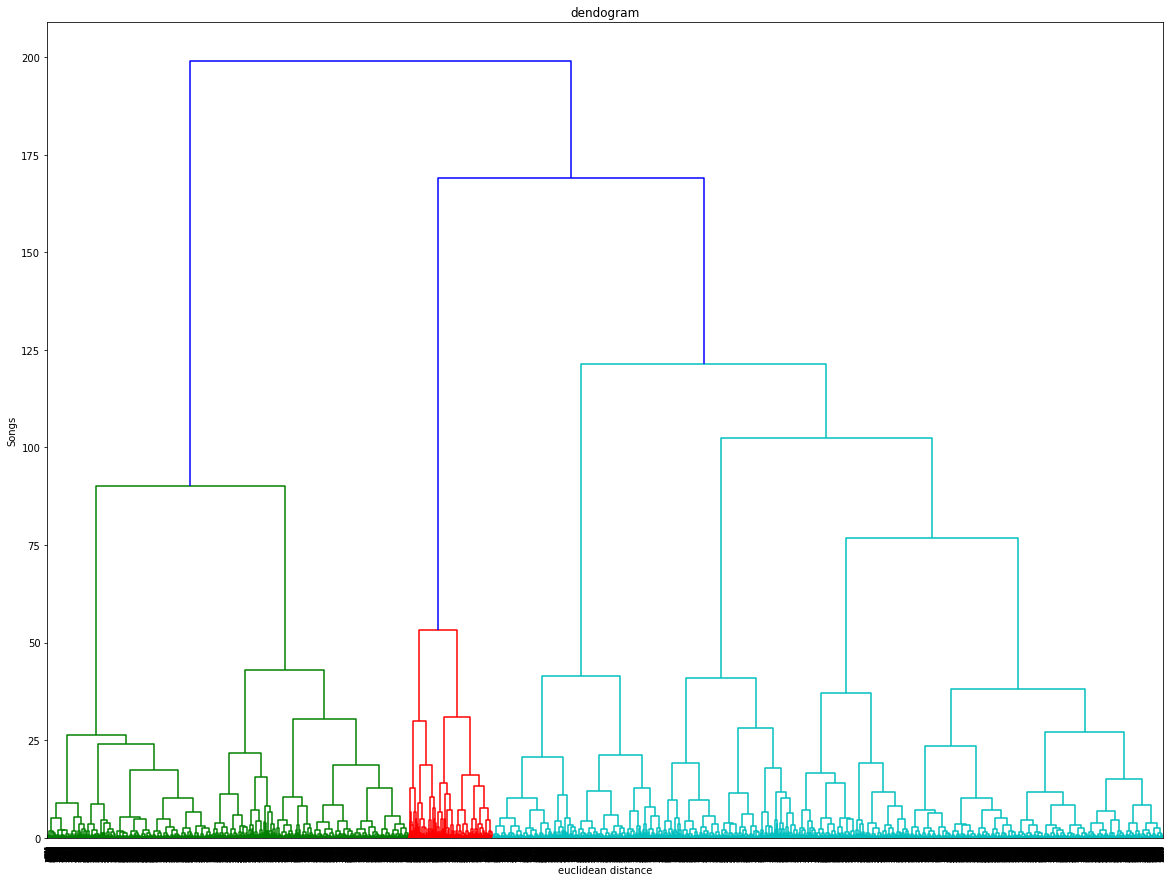

In [13]:
import scipy.cluster.hierarchy as shc


X_shuffled = X_principal.iloc[:,[0,1]].values

plt.figure(figsize=(20, 15))
dendro = shc.dendrogram(shc.linkage(X_shuffled , method = 'ward'))
plt.title('dendogram')
plt.xlabel('euclidean distance')
plt.ylabel('Songs')
plt.show()

In [14]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage = 'ward')
y_predict_shuffled = hc.fit_predict(X_shuffled)

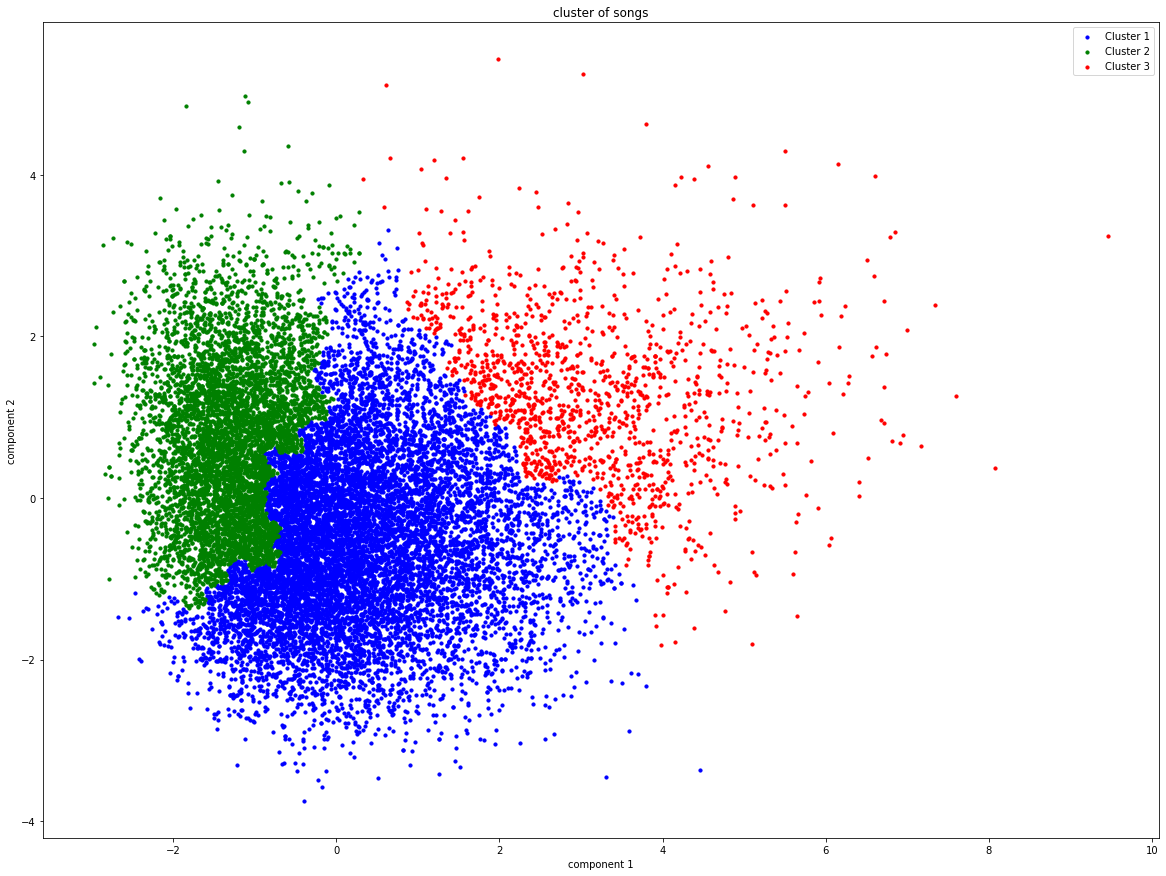

In [15]:
plt.figure(figsize=(20, 15))

plt.scatter(X_shuffled[y_predict_shuffled == 0,0],X_shuffled[y_predict_shuffled == 0,1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(X_shuffled[y_predict_shuffled == 1,0],X_shuffled[y_predict_shuffled == 1,1], s = 10, c = 'green', label = 'Cluster 2')
plt.scatter(X_shuffled[y_predict_shuffled == 2,0],X_shuffled[y_predict_shuffled == 2,1], s = 10, c = 'red', label = 'Cluster 3')
plt.title('cluster of songs')
plt.xlabel('component 1')
plt.ylabel("component 2")
plt.legend()
plt.show()

# DBSCAN model
##### The DBSCAN algorithm can help find clusters with an arbitrary shape.
##### K Means and Agglomerative clustering find clusters with a convex shape and this can have seeral disadvantages
##### DBSCAN overcomes this issue 
##### This algorithm is also perfect for outlier detection

##### We perfom the DBSCAN clustering using default parameters and see the output

In [17]:
from sklearn.cluster import DBSCAN

db_default = DBSCAN().fit(X_principal)
labels = db_default.labels_
set(labels)

{-1, 0, 1}

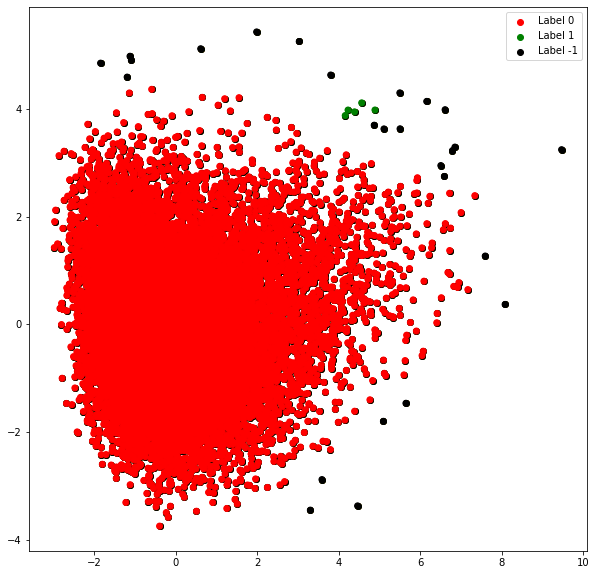

In [18]:
plt.figure(figsize=(10, 10))

colours = {}
colours[0] = 'r'
colours[1] = 'g'
colours[-1] = 'k'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]
  
# For the construction of the legend of the plot
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r');
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g');
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k');

# Plotting P1 on the X-Axis and P2 on the Y-Axis according to the colour vector defined

plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)

  
# Building the legend
plt.legend((r, g, k), ('Label 0', 'Label 1', 'Label -1'))
   
plt.show()

## Optimizing parameters for DBSCAN
##### The default parameters gives clusters which are vague.
##### Tuning the parameters woulg give a better result

In [19]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_principal)
distances, indices = nbrs.kneighbors(X_principal)

##### To find the optimal epsilon value, we plot the K distance graph and note the Y value at the point where the graph has a curve.
##### We take the value to be 0.3 here
##### The min points are chosen by trial and error and we settle at a value of 25 

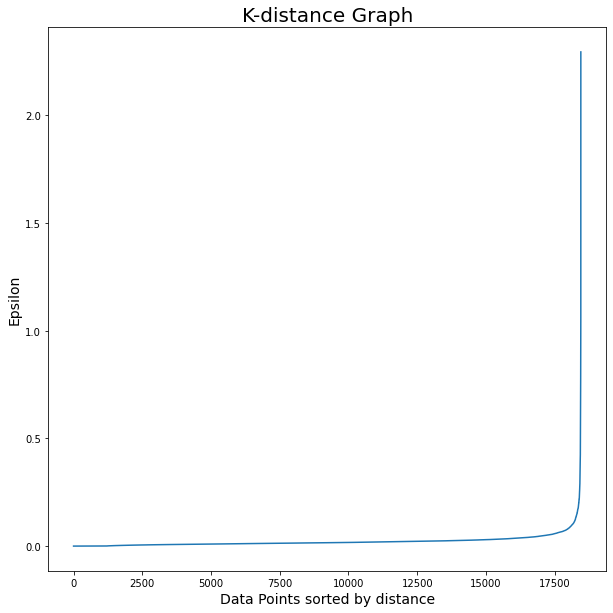

In [20]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

#optimal epsilon value is 0.3, and let minpts be 25

##### We now do the DBSCAN clustering again but with optimised parameters
##### We now get 8 clusters as compared to the original 3

In [21]:
db_default = DBSCAN(eps=0.16,min_samples=25).fit(X_principal)
labels = db_default.labels_
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6}

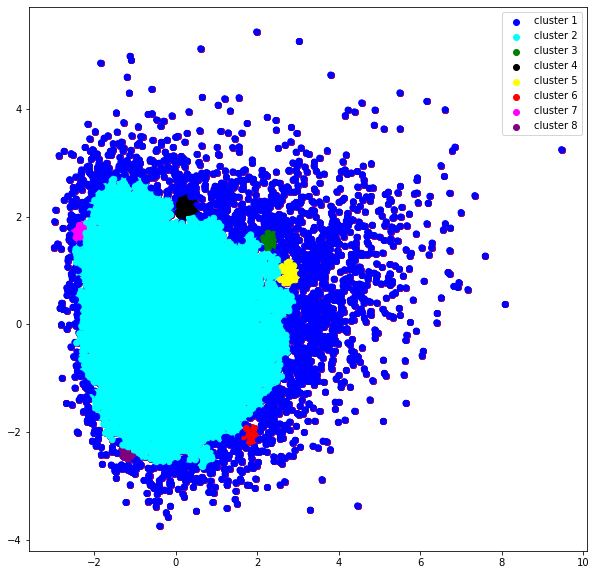

In [34]:
plt.figure(figsize=(10, 10))

colours = {}
colours[-1] = 'blue'
colours[0] = 'cyan'
colours[1] = 'green'
colours[2] = 'black'
colours[3] = 'yellow'
colours[4] = 'red'
colours[5] = 'magenta'
colours[6] = 'purple'



  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]
  
# For the construction of the legend of the plot
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='blue');

r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='cyan');
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='green');
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='black');
y = plt.scatter(X_principal['P1'], X_principal['P2'], color ='yellow');
c = plt.scatter(X_principal['P1'], X_principal['P2'], color ='red');

m = plt.scatter(X_principal['P1'], X_principal['P2'], color ='magenta');
p = plt.scatter(X_principal['P1'], X_principal['P2'], color ='purple');

# Plotting P1 on the X-Axis and P2 on the Y-Axis 
# according to the colour vector defined
#plt.figure(figsize =(9, 9))
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)

  
# Building the legend
plt.legend((k, r, g, b, y, c, m, p), ('cluster 1','cluster 2', 'cluster 3','cluster 4','cluster 5','cluster 6', 'cluster 7',
                                                               'cluster 8'))
   
plt.show()

# PAM (K-Mediod) Clustering Approach

##### The KMediod approach is a better version of the Kmeans algorithm as it can deal with outliers unlike Kmeans.
##### we see the cluster output and use the same number of clusters as that of kmeans

In [23]:
from sklearn_extra.cluster import KMedoids

# use same number of clusters as KMEANS
kMedoids = KMedoids(n_clusters = 8, random_state = 42)
y_kmed = kMedoids.fit_predict(X)

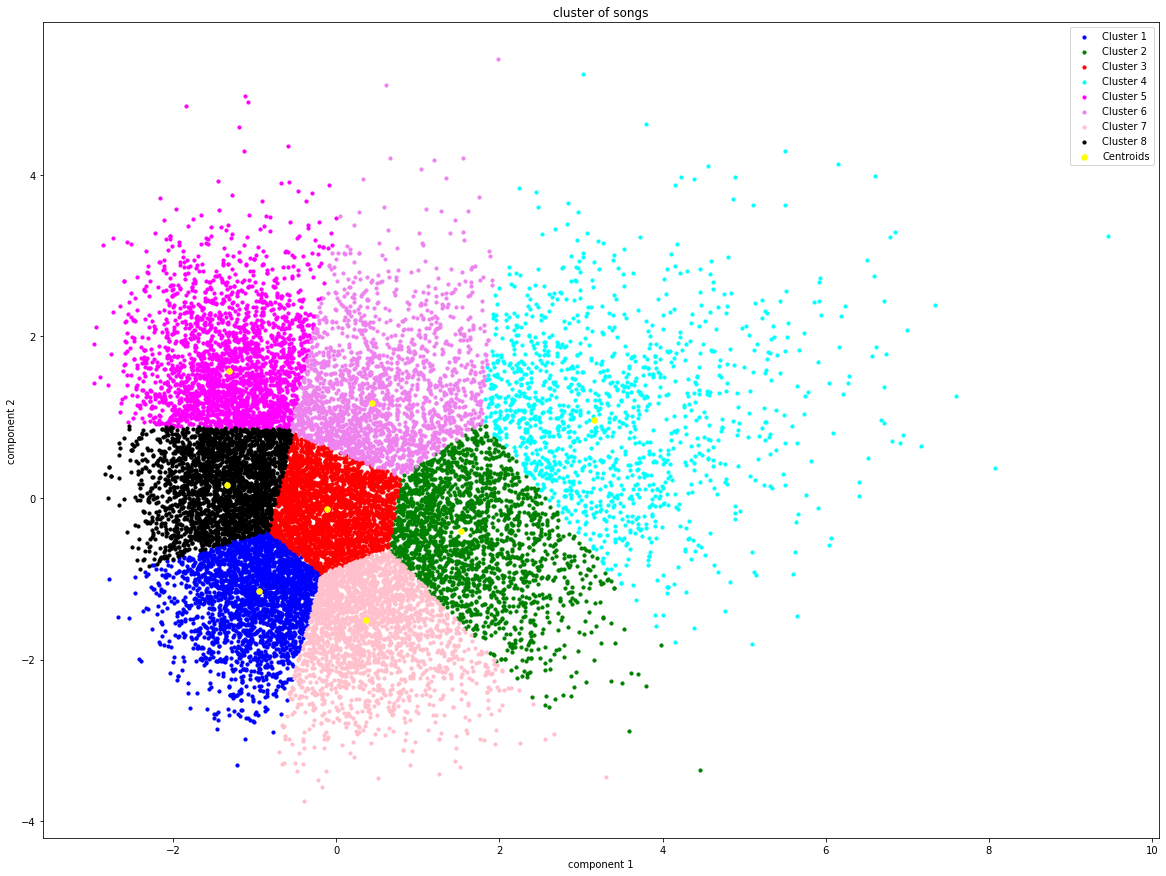

In [37]:
# visualization code
plt.figure(figsize=(20, 15))


plt.scatter(X[y_kmed == 0,0],X[y_kmed == 0,1], s = 10, c = 'blue', label = 'Cluster 1')
plt.scatter(X[y_kmed == 1,0],X[y_kmed == 1,1], s = 10, c = 'green', label = 'Cluster 2')
plt.scatter(X[y_kmed == 2,0],X[y_kmed == 2,1], s = 10, c = 'red', label = 'Cluster 3')
plt.scatter(X[y_kmed == 3,0],X[y_kmed == 3,1], s = 10, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmed == 4,0],X[y_kmed == 4,1], s = 10, c = 'magenta', label = 'Cluster 5')

plt.scatter(X[y_kmed == 5,0],X[y_kmed == 5,1], s = 10, c = 'violet', label = 'Cluster 6')
plt.scatter(X[y_kmed == 6,0],X[y_kmed == 6,1], s = 10, c = 'pink', label = 'Cluster 7')
plt.scatter(X[y_kmed == 7,0],X[y_kmed == 7,1], s = 10, c = 'black', label = 'Cluster 8')


plt.scatter(kMedoids.cluster_centers_[:,0],kMedoids.cluster_centers_[:,1], s=30,c='yellow',label = 'Centroids')
plt.title('cluster of songs')
plt.xlabel('component 1')
plt.ylabel("component 2")
plt.legend()

# Summary and Conclusion
#### We have seen the clustering output of 4 different algorithms. The number of clusters we get from each of these algorithms are as follows:
1.   K means : 8
2.   K Mediods : 8
3.   Agglomerative : 3
4.   DBSCAN : 8


#### In our use case of creating a playlist of songs, we generally prefer a larger variety of clusters, as each cluster would form a seperate playlist. Hence, we eliminate the the Agglomerative approach.
#### The DBSCAN algorithm gives us 8 clusters but a few clusters have a huge collection of data points and the other clusters have a very small number of data points. We would like all songs to be somewhat equally distributed in our playlists and this won't be possible following the DBSCAN approach, hence we eliminate the DBSCAN approach for this use case
#### This leaves us with the KMeans and KMediod algorithms. The KMeans performs well provided there are no outliers, while the KMediod handles outliers well
#### If outliers haven't been dealt with, then KMediod would be the preferred choice, and if outliers are dealt with then KMeans would be the preferred choice for this use case

##### Note: This conclusion pertains to this use case of creating playlists only. There are several real world cases were DBSCAN and Agglomerative algorithms perform much better than KMeans and KMediod
